In [1]:
from torch import stack
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import torch

In [4]:
class TagVocabulary():
    def __init__(self, tags_to_ix_path):
        with open(tags_to_ix_path,'rb') as f:
                self.tags_to_ix = pickle.load(f)
        self.ix_to_tag = {val:key for key,val in self.tags_to_ix.items()}
        self.stop = self.convert_tag('STOP')
    
    def __len__(self):
        return len(self.tags_to_ix)
    
    def __call__(self,tags):
        s_tags = map(lambda x: ''.join(sorted(x)),tags)
        c_tags = list(map(lambda x: self.convert_tag(x), s_tags))
        c_tags.append(self.stop)
        return torch.LongTensor(c_tags)
    
    def convert_tag(self,tag):
        s_tag = ''.join(sorted(tag))
        if not s_tag in self.tags_to_ix:
            s_tag = 'KNU'
        return self.tags_to_ix[s_tag]
    
    def revert_to_tag(self,num):
        return self.ix_to_tag[num]
    
    def is_stop(self,tag):
        return tag == self.stop

class GraspDataset(Dataset):
    def __init__(self, folder, data, transform, vocab):
        self.root_dir = folder
        self.X = data['X']
        self.y = data['y']
        self.transform = transform
        self.vocab = vocab
        
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # get images
        location = self.X.loc[idx]
        path = os.path.join(self.root_dir+'Grasping/Squared/', location)
        images = []
        for i in range(4):
            image = Image.open(os.path.join(path,"square{}.jpg".format(i)))
            if self.transform:
                image = self.transform(image)
            images.append(image)

        # get object
        obj = int(self.y.loc[idx]['object'])

        # get labels
        labels = self.y.loc[idx]['labels']
        labels = self.vocab(labels)

        return stack(images), labels, obj    


# we are going to send the different views to different models so we'll group them together
# in a batch with a custom collate fn (otherwise each element of the batch would have different views)
def views_collate(batch):
    # batch is a list of batch_size pairs(views, label, obj)
    # getting the object is easy, for each pair in batch, get the third element
    # then we convert it to a LongTensor
    objects = [item[2] for item in batch]
    objects = torch.LongTensor(objects)

    # getting the labels is similar, but we also need to pad them
    labels = [item[1] for item in batch]
    lengths = []

    labels = [item[1] for item in batch]
    lengths = torch.LongTensor([len(x) for x in labels]) # get the lengths to add some padding
    temp = torch.zeros(len(labels), max(lengths)).long()
    for i, tag in enumerate(labels):
        end = lengths[i]
        temp[i, :end] = tag[:end]
    labels = temp

    # getting the views is a little trickier
    sample_views = [ el[0] for el in batch] # gets the 4 views of each sample
    # stack the same views together in a mini-batch tensor
    views = [stack([view[i] for view in sample_views]) for i in range(4)]
    # now views is a 4-list of tensors (batch_size,1,224,224) ready to be fed into a model

    sorted_lengths, sort_idx = lengths.sort(0,descending=True)
    sorted_views = [view[sort_idx] for view in views]
    sorted_labels = labels[sort_idx]
    sorted_objects = objects[sort_idx]

    return sorted_views, sorted_labels, sorted_lengths, sorted_objects

def get_loaders(folder, split=0.2, dataset='full', batch_size=4, shuffle=True, num_workers=2, pin_memory=False,seed=42):
    df = pandas.read_pickle(folder +'/Grasping/Squared/metadata.pkl.compress', compression='gzip')

    ix_to_obj = list(pandas.read_pickle(folder+'/Grasping/Squared/index.pkl.compress', compression='gzip'))
    obj_to_ix = {}
    for idx,el in enumerate(list(ix_to_obj)):
        obj_to_ix[el] = idx

    if dataset == 'valid':
        df = df[df['hot'] == False] # exclude hot
        df = df[df['impaired'] == False] # exclude impaired
        df = df[df['failed'] == False] # exclude failed
        df.index = list(range(len(df)))

    grasping_df = df[['new_location','object','labels']]

    objs = set(df['object'])
    one_out_objs = {}
    for obj in objs:
        positive = grasping_df[grasping_df['object'] == obj]
        negative = grasping_df[grasping_df['object'] != obj]
        one_out_objs[obj] = {'positive':positive,'negative':negative}

    X = grasping_df['new_location']
    y = grasping_df[['object','labels']]

    splits = {}
    splits['train'] = {}
    splits['valid'] = {}
    splits['test'] = {}
    splits['train']['X'], splits['valid']['X'], splits['train']['y'], splits['valid']['y'] = train_test_split(X, y, test_size=split[0], random_state=seed)
    splits['test']['X'], splits['valid']['X'], splits['test']['y'], splits['valid']['y'] = train_test_split(splits['valid']['X'], splits['valid']['y'], test_size=split[1], random_state=seed)
    
    datasets = {}
    im_size = 224
    transform = transforms.Compose([
        transforms.RandomRotation(3, resample=PIL.Image.BILINEAR, expand=False, center=None),
        transforms.Resize(im_size + 20),
        transforms.RandomCrop(im_size),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0.1),
        transforms.ToTensor()
    ])
    vocab = TagVocabulary(folder+'/Grasping/code/data/tags_to_ix.pkl')
    
    for key,val in splits.items():
        val['X'] = val['X'].reset_index(drop=True) # reset indexes messed up after the split
        val['y'] = val['y'].reset_index(drop=True)

        data= {'X': val['X'].copy(), 'y' : val['y'].copy()}
        data['y']['object'] = data['y']['object'].apply(lambda x: obj_to_ix[x]) #translate objects

        datasets[key] = GraspDataset( folder=folder, data=data, transform=transform, vocab=vocab)

    loaders = {}
    display = Display(datasets, im_size, index=ix_to_obj)
    
    for key,val in datasets.items():
        loaders[key] = DataLoader(  val,
                                    batch_size=batch_size, 
                                    shuffle=shuffle, 
                                    num_workers=num_workers, 
                                    pin_memory=pin_memory,
                                    collate_fn = views_collate)
    return loaders, display, vocab
    
class Display():
    def __init__(self, datasets, im_size, index):
        self.im_size = im_size
        self.index = index
        self.datasets = datasets
    
    def translate_obj(self,label):
        return self.index[label]
        
    def plot_set(self, source, element, figsize=(12, 6), rows=2, titles=None):
        ims = self.datasets[source][element][0]
        title = self.translate_obj(self.datasets[source][element][2])
        f = plt.figure(figsize=figsize)
        plt.title(title, fontsize=16)
        plt.axis('Off')
        cols = len(ims) // rows if len(ims) % 2 == 0 else len(ims) // rows + 1
        for i in range(len(ims)):
            sp = f.add_subplot(rows, cols, i + 1)
            plt.imshow(np.array(ims[i]).reshape(self.im_size,self.im_size), interpolation=None, cmap='gray')

    # use this function to plot the first 4 views from a batch along with the obj_label
    def plot_views_objects(self, el, views, objects, figsize=(12, 6), rows=2, titles=None):
        ims = [x[el] for x in views] # get views
        title = self.translate_obj(objects[el]) # get the obj_label
        f = plt.figure(figsize=figsize)
        plt.title(title, fontsize=16)
        plt.axis('Off')
        cols = len(ims) // rows if len(ims) % 2 == 0 else len(ims) // rows + 1
        for i in range(len(ims)):
            sp = f.add_subplot(rows, cols, i + 1)
            plt.imshow(np.array(ims[i]).reshape(self.im_size,self.im_size), interpolation=None, cmap='gray')

    def plot_tensor(self,tensor):
        return transforms.ToPILImage()(tensor)

In [16]:
#loaders, display, vocab = get_loaders(folder = '/home/frati/', split = (0.3,0.5), dataset='full',batch_size=7,shuffle=True,num_workers=2)

In [17]:
#print(len(loaders['train']))
#print(len(loaders['valid']))
#print(len(loaders['test']))

431
93
93


In [199]:
#views, labels, lengths, objects = next(iter(loaders['train']))

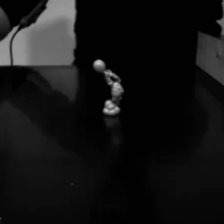

In [193]:
#display.plot_tensor(views[0][2])

In [188]:
#display.translate_obj(objects[1])

'rubber_band'

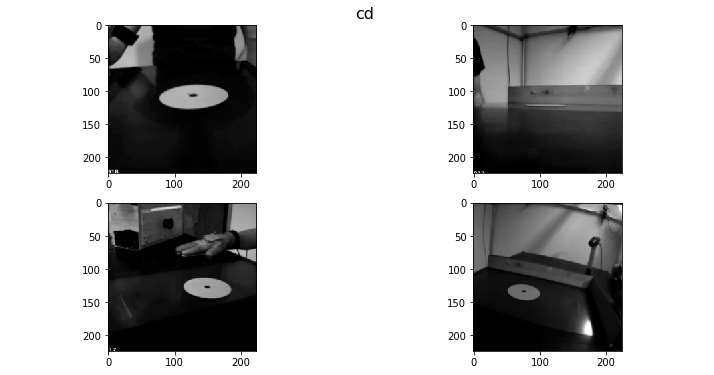

In [192]:
# check dataset
#display.plot_set('train',42)

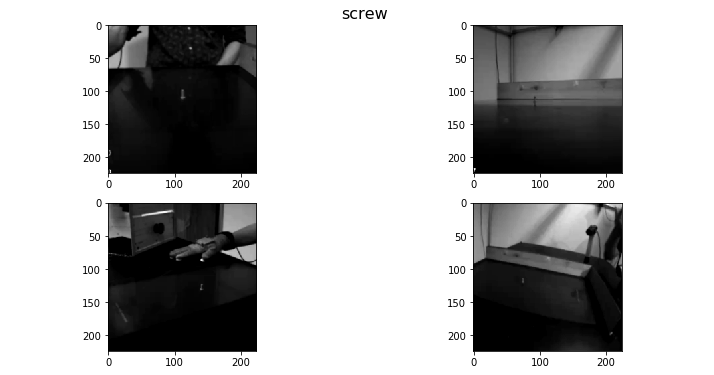

In [208]:
#display.plot_views_objects(6,views,objects)

In [67]:
# folder = '/home/frati/'
# split=0.02

# df = pandas.read_pickle(folder +'/Grasping/Squared/metadata.pkl.compress', compression='gzip')

# ix_to_obj = list(pandas.read_pickle(folder+'/Grasping/Squared/index.pkl.compress', compression='gzip'))
# obj_to_ix = {}
# for idx,el in enumerate(list(ix_to_obj)):
#     obj_to_ix[el] = idx

# grasping_df = df[['new_location','object','labels']]

# objs = set(df['object'])
# one_out_objs = {}
# for obj in objs:
#     positive = grasping_df[grasping_df['object'] == obj]
#     negative = grasping_df[grasping_df['object'] != obj]
#     one_out_objs[obj] = {'positive':positive,'negative':negative}

# X = grasping_df['new_location']
# y = grasping_df[['object','labels']]

# splits = {}
# splits['train'] = {}
# splits['valid'] = {}
# coverage = 0
# while (coverage < len(obj)):
#     splits['train']['X'], splits['valid']['X'], splits['train']['y'], splits['valid']['y'] = train_test_split(X, y, test_size=split)
#     coverage = splits['valid']['y']['object'].nunique()